In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
import re
import seaborn as sns
warnings.filterwarnings('ignore')

# ANALYTICS/MODEL BUILDING

## import analytical libraries

In [1]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, r2_score, average_precision_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import plot_roc_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Read in data

In [4]:
### Team level data (use recent 10 games average and official NBA elo rating data)
recent_nba_elo_df = pd.read_csv('teams_recent_stats.csv', index_col = 0)

### Team level data (use recent 10 games average and calculated NBA elo rating data)
recent_team_elo_df = pd.read_csv('DATA_team_recent_team_elo.csv')#, index_col = 0)

### player level aggregated data
player_team = pd.read_csv('DATA_player_team2.csv')#, index_col=0)

In [5]:
recent_nba_elo_df.head()

,SEASON_ID,GAME_ID,GAME_DATE,Team_Home,Team_Away,Home_Team_Won,H_Recent_OffRtg,H_Recent_DefRtg,H_Recent_NetRtg,H_Recent_AST%,...,A_Recent_PIE,A_Recent_FGM,A_Recent_FGA,A_Recent_FG_PCT,A_Recent_FG3M,A_Recent_FG3A,A_Recent_FG3_PCT,A_Recent_FTM,A_Recent_FTA,A_Recent_FT_PCT
0,22022,22200315,11/30/2022,BKN,WAS,1,113.81,113.54,0.28,64.75,...,53.13,42.4,88.8,0.4786,13.5,35.6,0.3806,16.1,20.9,0.7661
1,22022,22200313,11/30/2022,ORL,ATL,0,108.54,115.23,-6.67,54.99,...,48.25,40.1,88.5,0.4543,9.2,29.3,0.3128,20.3,24.2,0.8413
2,22022,22200320,11/30/2022,DEN,HOU,1,116.59,115.96,0.65,62.85,...,50.01,39.2,84.5,0.4641,13.1,35.9,0.3599,21.1,26.8,0.7824
3,22022,22200321,11/30/2022,PHX,CHI,1,117.49,113.10,4.39,59.95,...,49.46,42.7,88.4,0.4844,10.1,29.2,0.3345,16.3,20.2,0.8044
4,22022,22200316,11/30/2022,NYK,MIL,0,117.43,116.49,0.93,56.85,...,48.97,41.2,89.4,0.4628,12.9,35.8,0.3591,16.8,24.0,0.6986


In [6]:
recent_team_elo_df.head()

,SEASON_ID,GAME_ID,GAME_DATE,Team_Home,Team_Away,Home_Team_Won,H_Recent_OffRtg,H_Recent_DefRtg,H_Recent_NetRtg,H_Recent_AST%,...,A_Recent_FG3M,A_Recent_FG3A,A_Recent_FG3_PCT,A_Recent_FTM,A_Recent_FTA,A_Recent_FT_PCT,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After
0,22022,22200315,11/30/2022,BKN,WAS,1,113.81,113.54,0.28,64.75,...,13.5,35.6,0.3806,16.1,20.9,0.7661,1508.845873,1479.702191,1514.322866,1474.225198
1,22022,22200313,11/30/2022,ORL,ATL,0,108.54,115.23,-6.67,54.99,...,9.2,29.3,0.3128,20.3,24.2,0.8413,1514.335802,1476.034547,1494.701563,1495.668787
2,22022,22200320,11/30/2022,DEN,HOU,1,116.59,115.96,0.65,62.85,...,13.1,35.9,0.3599,21.1,26.8,0.7824,1501.430648,1536.070776,1516.617087,1520.884336
3,22022,22200321,11/30/2022,PHX,CHI,1,117.49,113.10,4.39,59.95,...,10.1,29.2,0.3345,16.3,20.2,0.8044,1499.039678,1492.765882,1511.413285,1480.392275
4,22022,22200316,11/30/2022,NYK,MIL,0,117.43,116.49,0.93,56.85,...,12.9,35.8,0.3591,16.8,24.0,0.6986,1512.233497,1540.532262,1503.790169,1548.975591


In [7]:
player_team.head()

,YM,TEAM,GAME_ID,WIN,PLAYER_WIN%,TEAM_WIN%,w_TS%_1,w_PIE_1,w_GAME_SCORE_1,w_+/-_1,w_PER_1,w_PPP_1,raptor_offense,raptor_defense,predator_offense,predator_defense
0,2015/11,ATL,21500039,1,0.810000,0.588235,4.675835,9.802316,8.719582,1.016775,13.874790,0.893310,-0.382755,0.845590,-0.204075,0.870344
1,2015/11,ATL,21500055,1,0.885714,0.588235,4.647828,6.794210,6.470584,-0.710061,9.757216,0.602191,-0.775310,0.323370,-0.427876,0.111958
2,2015/11,ATL,21500062,1,0.800000,0.588235,3.817465,7.731231,7.228008,0.212793,11.303082,0.738383,-0.962853,0.674803,-0.723511,0.574695
3,2015/11,ATL,21500081,1,0.810000,0.588235,4.560179,8.431909,8.089227,0.088191,12.361634,0.855764,-0.677957,0.661832,-0.445826,0.602772
4,2015/11,ATL,21500086,1,0.754545,0.588235,3.943707,8.766529,8.259330,0.564550,12.541544,0.802536,-0.822012,0.552367,-0.561523,0.556308


## Prepare for training

In [11]:
nba_elo_cols = ['H_Recent_NetRtg', 'H_Recent_REB%', 'H_Recent_FGA', 'H_Recent_FTM', 'H_Recent_FT_PCT', \
                'A_Recent_DefRtg', 'A_Recent_AST%', 'A_Recent_OREB%', 'A_Recent_DREB%', 'A_Recent_TOV%', \
                'A_Recent_PACE', 'A_Recent_FG3A', 'A_Recent_FG3_PCT', 'A_Recent_FTA', 'A_Recent_FT_PCT']

team_elo_cols = ['H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Recent_NetRtg', 'H_Recent_REB%', \
                 'H_Recent_FGA', 'H_Recent_FTM', 'H_Recent_FT_PCT', 'A_Recent_DefRtg', \
                 'A_Recent_AST%', 'A_Recent_OREB%', 'A_Recent_DREB%', 'A_Recent_TOV%', \
                 'A_Recent_PACE', 'A_Recent_FG3A', 'A_Recent_FG3_PCT', 'A_Recent_FTA', 'A_Recent_FT_PCT']

player_cols = ['PLAYER_WIN%', 'w_TS%_1', 'w_PIE_1', 'w_GAME_SCORE_1', 'w_+/-_1', 'w_PER_1', 'w_PPP_1', \
               'raptor_offense', 'raptor_defense', 'predator_offense', 'predator_defense']

In [12]:
X_nba_elo = recent_nba_elo_df[nba_elo_cols]
y_nba_elo = recent_nba_elo_df['Home_Team_Won']

X_team_elo = recent_team_elo_df[team_elo_cols]
y_team_elo = recent_team_elo_df['Home_Team_Won']

X_player = player_team[player_cols]
y_player = player_team['WIN']

In [13]:
one = y_nba_elo.value_counts().to_frame()
two = y_team_elo.value_counts().to_frame()
three = y_player.value_counts().to_frame()
pd.concat([one,two,three],axis=1)

,Home_Team_Won,Home_Team_Won,WIN
1,4845,4845,8068
0,3632,3632,8007


In [14]:
X1 = StandardScaler().fit_transform(X_nba_elo)
X2 = StandardScaler().fit_transform(X_team_elo)
X3 = StandardScaler().fit_transform(X_player)
# X1 = X_nba_elo
# X2 = X_team_elo
# X3 = X_player

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y_nba_elo, test_size=0.2, random_state=15, stratify=y_nba_elo)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y_team_elo, test_size=0.2, random_state=15, stratify=y_team_elo)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y_player, test_size=0.2, random_state=15, stratify=y_player)

### Logistic Regression

In [29]:
logRe = LogisticRegressionCV(cv=10, penalty='l2', max_iter=500, random_state=15)
from sklearn.model_selection import GridSearchCV

,team_recent,team_elo,player_team
F1_score,0.698268,0.695172,0.629426
R_square,-0.59377,-0.596178,-0.510445
MSE,0.39033,0.39092,0.377605
AUC,0.636983,0.639389,0.67467
ACC,0.60967,0.60908,0.622395


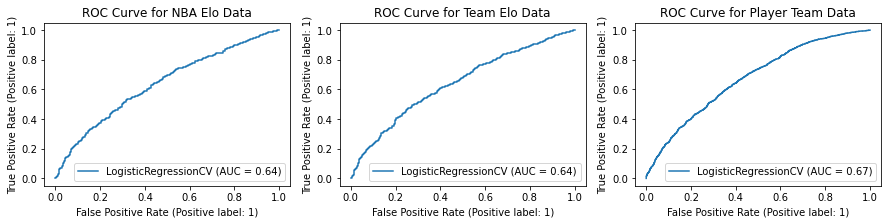

In [30]:
data = [(X_train1, y_train1, X_test1, y_test1),\
        (X_train2, y_train2, X_test2, y_test2),\
        (X_train3, y_train3, X_test3, y_test3)]

logRe_evaluation = pd.DataFrame(columns=['team_recent','team_elo','player_team'], \
                          index=['F1_score','R_square','MSE','AUC','ACC'])
cols = logRe_evaluation.columns.to_list()

i = 0
fig, ax = plt.subplots(1,3, figsize=(15,3))
ax[0].set_title('ROC Curve for NBA Elo Data')
ax[1].set_title('ROC Curve for Team Elo Data')
ax[2].set_title('ROC Curve for Player Team Data')

for xy_pair in data:
    X, y = xy_pair[:2]
    X_test, y_test = xy_pair[2:]
    logRe.fit(X, y)
    y_pred = logRe.predict(X_test)
    logRe_evaluation.loc['F1_score'][cols[i]] = f1_score(y_test, y_pred)
    logRe_evaluation.loc['R_square'][cols[i]] = r2_score(y_test, y_pred)
    logRe_evaluation.loc['MSE'][cols[i]] = mean_squared_error(y_test, y_pred)
    logRe_evaluation.loc['ACC'][cols[i]] = accuracy_score(y_test, y_pred)
    
    y_pred_prob = logRe.predict_proba(X_test)[:,1]
    logRe_evaluation.loc['AUC'][cols[i]] = roc_auc_score(y_test, y_pred_prob)
    
    plot_roc_curve(logRe, X_test, y_test, ax=ax[i])
    i += 1
    
logRe_evaluation

### Decision Tree

In [22]:
clf_dt = DecisionTreeClassifier(random_state=14)
param_grid = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
              "criterion": ['gini','entropy']}

# Grid search
grid_search = GridSearchCV(clf_dt, param_grid=param_grid)

Dataset: team_recent, best params: {'criterion': 'entropy', 'max_depth': 4}
Dataset: team_elo, best params: {'criterion': 'gini', 'max_depth': 4}
Dataset: player_team, best params: {'criterion': 'gini', 'max_depth': 5}


,team_recent,team_elo,player_team
F1_score,0.664748,0.668251,0.636179
R_square,-0.682848,-0.68044,-0.563945
MSE,0.412146,0.411557,0.39098
AUC,0.588636,0.589024,0.654041
ACC,0.587854,0.588443,0.60902


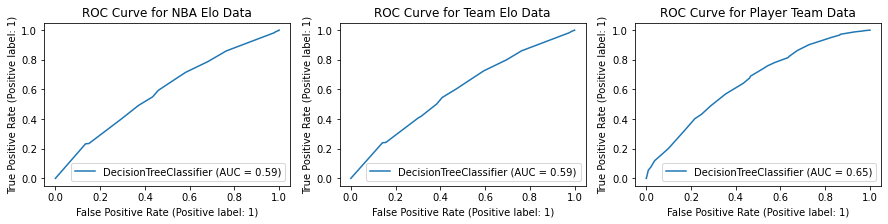

In [23]:
data = [(X_train1, y_train1, X_test1, y_test1),\
        (X_train2, y_train2, X_test2, y_test2),\
        (X_train3, y_train3, X_test3, y_test3)]

tree_evaluation = pd.DataFrame(columns=['team_recent','team_elo','player_team'], \
                          index=['F1_score','R_square','MSE','AUC','ACC'])
cols = tree_evaluation.columns.to_list()

i = 0
fig, ax = plt.subplots(1,3, figsize=(15,3))
ax[0].set_title('ROC Curve for NBA Elo Data')
ax[1].set_title('ROC Curve for Team Elo Data')
ax[2].set_title('ROC Curve for Player Team Data')

for xy_pair in data:
    X, y = xy_pair[:2]
    X_test, y_test = xy_pair[2:]
    
    grid_search.fit(X, y)
    print('Dataset: {}, best params: {}'.format(cols[i], grid_search.best_params_))
    clf_dt.set_params(**grid_search.best_params_)
    
    clf_dt.fit(X, y)
    y_pred = clf_dt.predict(X_test)
    tree_evaluation.loc['F1_score'][cols[i]] = f1_score(y_test, y_pred)
    tree_evaluation.loc['R_square'][cols[i]] = r2_score(y_test, y_pred)
    tree_evaluation.loc['MSE'][cols[i]] = mean_squared_error(y_test, y_pred)
    tree_evaluation.loc['ACC'][cols[i]] = accuracy_score(y_test, y_pred)
    
    y_pred_prob = clf_dt.predict_proba(X_test)[:,1]
    tree_evaluation.loc['AUC'][cols[i]] = roc_auc_score(y_test, y_pred_prob)
    
    plot_roc_curve(clf_dt, X_test, y_test, ax=ax[i])
    i += 1
    
tree_evaluation

### Random forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
param_grid = {"n_estimators": [1, 10, 50, 100],
              "max_features": [1, 5, 10, "auto"],
              "criterion": ['gini','entropy'],
              "random_state": [17]}

# Grid search
grid_search = GridSearchCV(clf_rf, param_grid=param_grid)

Dataset: team_recent, best params: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100, 'random_state': 17}
Dataset: team_elo, best params: {'criterion': 'entropy', 'max_features': 1, 'n_estimators': 100, 'random_state': 17}
Dataset: player_team, best params: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 100, 'random_state': 17}


,team_recent,team_elo,player_team
F1_score,0.669191,0.691057,0.626782
R_square,-0.682848,-0.646735,-0.498003
MSE,0.412146,0.403302,0.374495
AUC,0.616466,0.618556,0.654483
ACC,0.587854,0.596698,0.625505


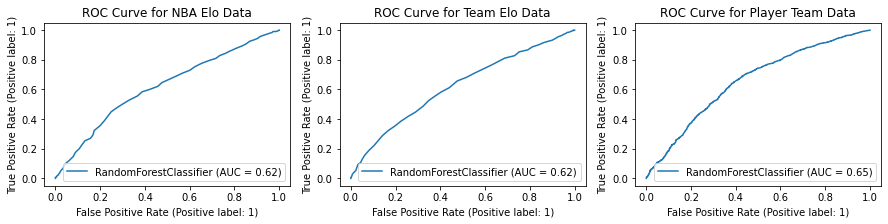

In [27]:
data = [(X_train1, y_train1, X_test1, y_test1),\
        (X_train2, y_train2, X_test2, y_test2),\
        (X_train3, y_train3, X_test3, y_test3)]

rf_evaluation = pd.DataFrame(columns=['team_recent','team_elo','player_team'], \
                          index=['F1_score','R_square','MSE','AUC','ACC'])
cols = rf_evaluation.columns.to_list()

i = 0
fig, ax = plt.subplots(1,3, figsize=(15,3))
ax[0].set_title('ROC Curve for NBA Elo Data')
ax[1].set_title('ROC Curve for Team Elo Data')
ax[2].set_title('ROC Curve for Player Team Data')

for xy_pair in data:
    X, y = xy_pair[:2]
    X_test, y_test = xy_pair[2:]
    grid_search.fit(X, y)
    
    print('Dataset: {}, best params: {}'.format(cols[i], grid_search.best_params_))
    
    clf_rf.set_params(**grid_search.best_params_)
    clf_rf.fit(X, y)
    y_pred = clf_rf.predict(X_test)
    rf_evaluation.loc['F1_score'][cols[i]] = f1_score(y_test, y_pred)
    rf_evaluation.loc['R_square'][cols[i]] = r2_score(y_test, y_pred)
    rf_evaluation.loc['MSE'][cols[i]] = mean_squared_error(y_test, y_pred)
    rf_evaluation.loc['ACC'][cols[i]] = accuracy_score(y_test, y_pred)
    
    y_pred_prob = clf_rf.predict_proba(X_test)[:,1]
    rf_evaluation.loc['AUC'][cols[i]] = roc_auc_score(y_test, y_pred_prob)
    
    plot_roc_curve(clf_rf, X_test, y_test, ax=ax[i])
    i += 1
    
rf_evaluation

### XGBoost

In [24]:
import xgboost
clf_xgb = xgboost.XGBClassifier()

param_grid = {"n_estimators": [10, 100],
          "learning_rate": [0.01, 0.1, 0.5],
          "random_state": [17]
          }

# Grid search
grid_search = GridSearchCV(clf_xgb, param_grid=param_grid)

Dataset: team_recent, best params: {'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 17}
Dataset: team_elo, best params: {'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 17}
Dataset: player_team, best params: {'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 17}


,team_recent,team_elo,player_team
F1_score,0.680891,0.678439,0.654472
R_square,-0.656365,-0.665995,-0.480584
MSE,0.40566,0.408019,0.37014
AUC,0.612158,0.608399,0.680841
ACC,0.59434,0.591981,0.62986


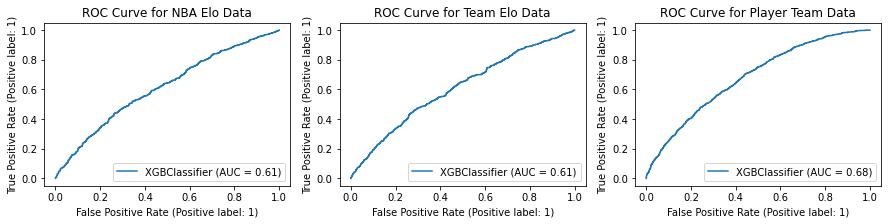

In [25]:
data = [(X_train1, y_train1, X_test1, y_test1),\
        (X_train2, y_train2, X_test2, y_test2),\
        (X_train3, y_train3, X_test3, y_test3)]

xg_evaluation = pd.DataFrame(columns=['team_recent','team_elo','player_team'], \
                          index=['F1_score','R_square','MSE','AUC','ACC'])
cols = xg_evaluation.columns.to_list()

i = 0
fig, ax = plt.subplots(1,3, figsize=(15,3))
ax[0].set_title('ROC Curve for NBA Elo Data')
ax[1].set_title('ROC Curve for Team Elo Data')
ax[2].set_title('ROC Curve for Player Team Data')

for xy_pair in data:
    X, y = xy_pair[:2]
    X_test, y_test = xy_pair[2:]
    grid_search.fit(X, y)
    
    print('Dataset: {}, best params: {}'.format(cols[i], grid_search.best_params_))
    
    clf_xgb.set_params(**grid_search.best_params_)
    clf_xgb.fit(X, y)
    y_pred = clf_xgb.predict(X_test)
    xg_evaluation.loc['F1_score'][cols[i]] = f1_score(y_test, y_pred)
    xg_evaluation.loc['R_square'][cols[i]] = r2_score(y_test, y_pred)
    xg_evaluation.loc['MSE'][cols[i]] = mean_squared_error(y_test, y_pred)
    xg_evaluation.loc['ACC'][cols[i]] = accuracy_score(y_test, y_pred)
    
    y_pred_prob = clf_xgb.predict_proba(X_test)[:,1]
    xg_evaluation.loc['AUC'][cols[i]] = roc_auc_score(y_test, y_pred_prob)
    
    plot_roc_curve(clf_xgb, X_test, y_test, ax=ax[i])
    i += 1
    
xg_evaluation

In [73]:
colors = {'LogistricRegression':'#0751d9',\
          'DecisionTree':'#3974e1',\
          'RandomForest':'#6a97e8',\
          'XGBoost':'#cddcf7'}#'#9cb9f0'}

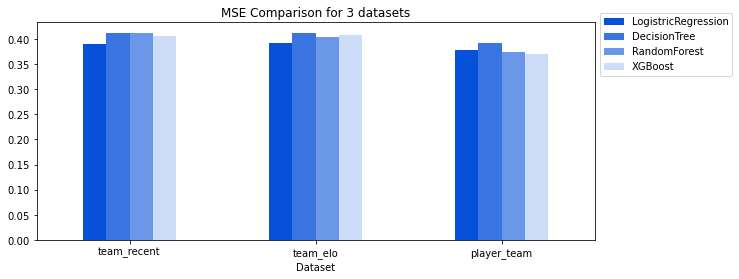

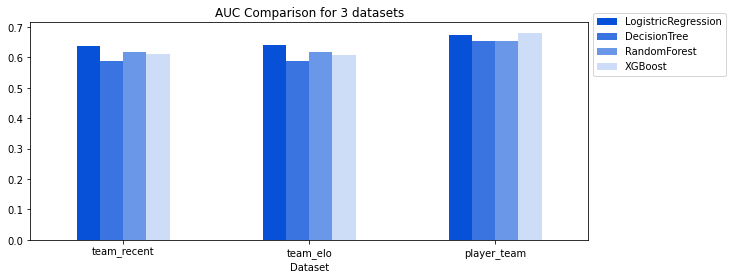

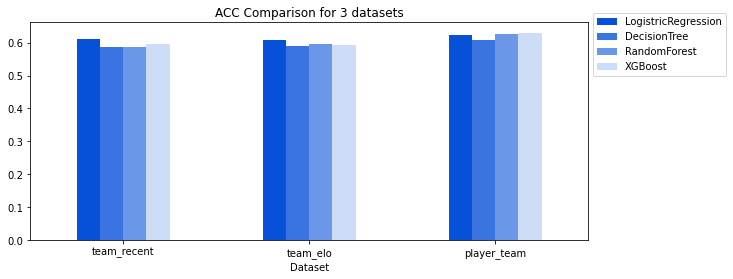

In [74]:
metrics_df = [logRe_evaluation, tree_evaluation, rf_evaluation, xg_evaluation]

data_names = ['team_recent','team_elo','player_team']
metric_names = ['MSE','AUC','ACC']

model = ['LogistricRegression','DecisionTree','RandomForest','XGBoost']

for metric in metric_names:
    new = pd.DataFrame(columns=data_names, index=model)
    i = 0
    for data in data_names:
        for m_df in metrics_df:
            new.loc[model[i], data] = m_df.loc[metric,data]
            i += 1
        i = 0

    new = new.transpose().reset_index().rename(columns={'index':'Dataset'})
    new.plot(x='Dataset',kind='bar',rot=0,stacked=False, color=colors, figsize=(10,4),\
              title='{} Comparison for 3 datasets'.format(metric))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))